In [20]:
#Librarie importation
import  pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
#Load dataset
df = pd.read_csv("mining_logistics.csv")
print(df.head())
print(df.describe())

                  date                     origin                    destiny  \
0  2023-03-13 00:00:00                Gral Guemes              Salta Capital   
1  2023-01-26 16:00:00              Salta Capital  San Antonio de los Cobres   
2  2023-03-16 21:00:00  San Antonio de los Cobres           Salar de Pocitos   
3  2023-08-23 19:00:00              Salta Capital  San Antonio de los Cobres   
4  2023-06-07 22:00:00                Gral Guemes              Salta Capital   

   altitude_destiny_mbsl  distance_km    unit_type  charge_tons weather  \
0                   1187           59  semitrailer        25.68   clear   
1                   3775          170    4x4 truck        39.08    rain   
2                   3650          108  semitrailer        44.54   clear   
3                   3775          170  semitrailer        34.71   clear   
4                   1187           59    4x4 truck        39.16   clear   

   driver_experience_years  theorical_time_arrival_hs  real_time_hs 

In [22]:
#Feature engineering
#Calculate delay and cost
df['delay_hs'] = df['real_time_hs'] - df['theorical_time_arrival_hs']

#Only count positive delays
df['delay_hs'] = df['delay_hs'].clip(lower=0)

#Assumption: each hour of delay cost 500 usd
cost_hour_delay = 500
df['cost_delay_usd'] = df['delay_hs'] * cost_hour_delay

#Weather analysis
weather_impact = df.groupby('weather')['cost_delay_usd'].agg(['mean', 'sum']).reset_index()

print("--- Economic Impact Due To Climate ---")
print(weather_impact)

--- Economic Impact Due To Climate ---
      weather         mean        sum
0       clear   497.961533  7029225.0
1        rain  2512.080925  7388030.0
2        snow  2517.699805  2583160.0
3  white wind  2489.893062  4773125.0


C:\Users\acer\AppData\Local\Temp\ipykernel_3892\2572072.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='weather', y='real_time_hs', data=df, palette='viridis')


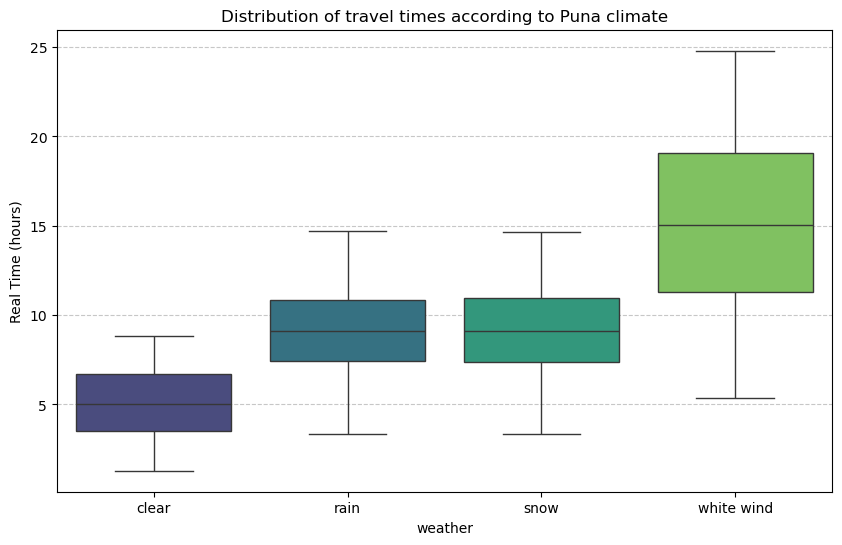

In [23]:
#Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather', y='real_time_hs', data=df, palette='viridis')
plt.title('Distribution of travel times according to Puna climate')
plt.ylabel('Real Time (hours)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('weather_analysis.png')
plt.show()

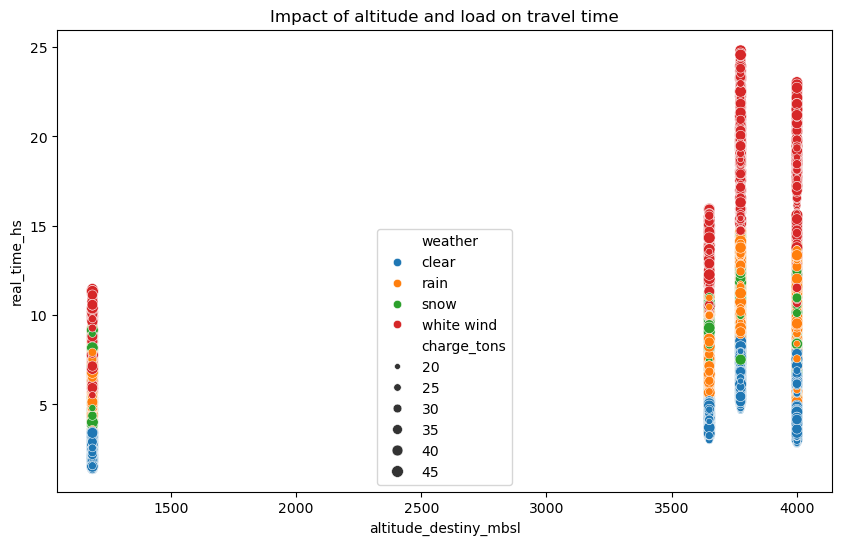

In [24]:
#Altitude vs consumption analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='altitude_destiny_mbsl', y='real_time_hs', hue='weather', size='charge_tons', data=df)
plt.title('Impact of altitude and load on travel time')
plt.savefig('altitude_vs_time.png')
plt.show()

In [25]:
#Import libraries ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [26]:
#Selection of features and objetive
#Objective "real_time_hs"
features = ['altitude_destiny_mbsl', 'distance_km', 'unit_type', 'charge_tons', 'weather',
            'driver_experience_years']

X = df[features]
Y = df['real_time_hs']

#Transformation of categorical variables
categorical_features = ['unit_type', 'weather']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough'
)

In [27]:
#Definition of base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=123)),
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=123))
]

#Definition of meta-model (final estimator)
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=RidgeCV()
)

#Complete pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', stacking_model)
])

#Split and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)
model_pipeline.fit(X_train, Y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [28]:
#Predictions
Y_pred = model_pipeline.predict(X_test)

#Metrics
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"--- Model Perfomance ---")
print(f"MAE (Mean Absolute Error): {mae:.2f} hours")
print(f"R2 Score: {r2:.4f}")

--- Model Perfomance ---
MAE (Mean Absolute Error): 0.80 hours
R2 Score: 0.9236


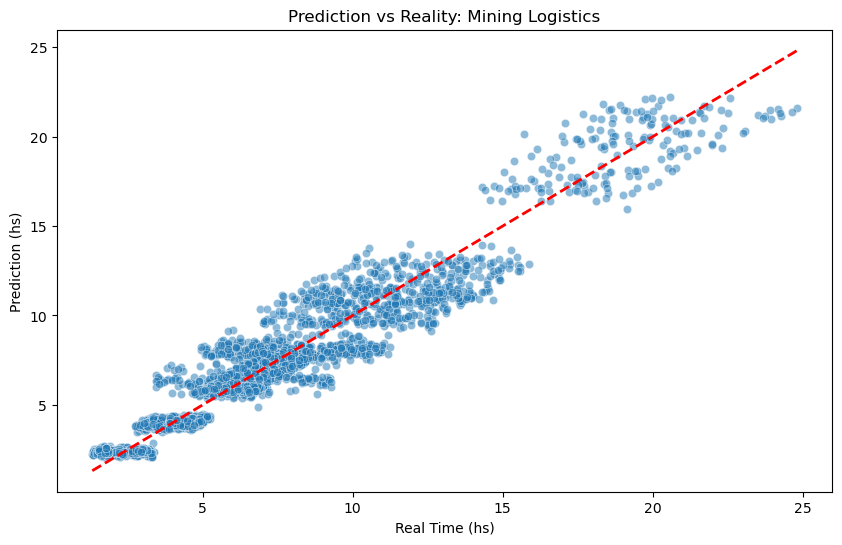

In [29]:
#Visualize predictions vs reality
plt.figure(figsize=(10, 6))
sns.scatterplot(x=Y_test, y=Y_pred, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--r', lw=2)
plt.xlabel('Real Time (hs)')
plt.ylabel('Prediction (hs)')
plt.title('Prediction vs Reality: Mining Logistics')
plt.show()

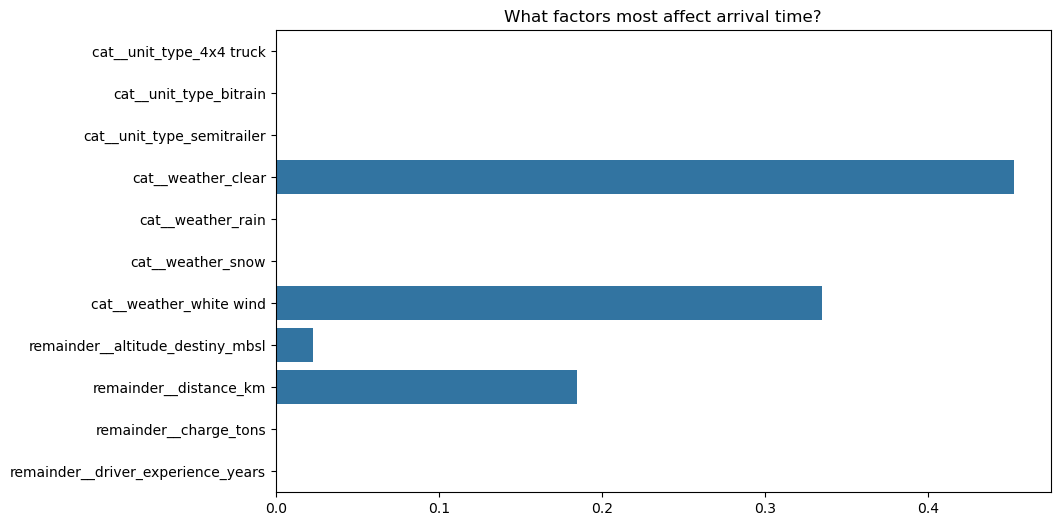

In [30]:
#Feature importance
#Extract xgboost model from pipeline
xgb_model = model_pipeline.named_steps['regressor'].estimators_[1]
importances = xgb_model.feature_importances_

#Get column names after the one hot encoder
features_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()

#Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features_names)
plt.title('What factors most affect arrival time?')
plt.savefig('features_importances.png')
plt.show() 

In [31]:
#Save trained model
import joblib

joblib.dump(model_pipeline, 'mining_logistics_model.joblib', compress=3)
print("Model saved as 'mining_logistics_model.joblib'")

Model saved as 'mining_logistics_model.joblib'


In [32]:
#Generate predictions for the entire dataset 
#This allows you to compare actual vs predicted 
df['predicted_time_hs'] = model_pipeline.predict(df[features])
df['error_abs_hs'] = abs(df['real_time_hs'] - df['predicted_time_hs'])

#Export data
df.to_csv("data_tableau.csv", index=False)
print("Data for tableau exported as 'data_tableau.csv'")

Data for tableau exported as 'data_tableau.csv'
